# Simulação DC - Lumerical FDTD

In [1]:
import sys, os, imp
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import lambda2nu, nu2lambda, c

In [87]:
lumapiFile = "C:\\Program Files\\Lumerical\\v211\\api\\python\\lumapi.py"
lumapi   = imp.load_source("lumapi", lumapiFile)
fdtdApi  = lumapi.FDTD(hide = False)

Exception ignored in: <function Lumerical.__del__ at 0x0000019A2E753378>
Traceback (most recent call last):
  File "C:\Program Files\Lumerical\v211\api\python\lumapi.py", line 1171, in __del__
    close(self.handle)
  File "C:\Program Files\Lumerical\v211\api\python\lumapi.py", line 241, in close
    iapi.appClose(handle)
ctypes.ArgumentError: argument 1: <class 'TypeError'>: expected Session instance instead of Session


In [88]:
# DC macro parameters
lc  = 1e-6
gap = 150e-9
rad = 5e-6
portSize = 2e-6
# Waveguide parameters
wvg_width = 450e-9
wvg_height = 210.1e-9
# Bandwidth operation
cband = True
filename = "S_sata_FDTD_%d_nm_%03d_um" %(1e9*gap,1e6*lc)
# Materials
material_Clad = "SiO2 (Glass) - Dispersive & Lossless"
material_Si   = "Si (Silicon) - Dispersive & Lossless"

In [89]:
# C Band simulation: 1520 - 1575 nm
# L Band simulation: 1555 - 1635 nm
if cband:
    wvlngth_start = 1.520e-6
    wvlngth_stop  = 1.575e-6
else:
    wvlngth_start = 1.555e-6
    wvlngth_stop  = 1.635e-6    
nmbFrqPnts = 100

In [90]:
portBcDist = 6e-6
# FDTD parameters
x_FDTD = lc/2+2*rad
y_FDTD = -rad-gap/2-wvg_height
x_span_FDTD = lc+2*rad+portBcDist
y_span_FDTD = 2*rad+gap+2*wvg_width+portSize
z_span_FDTD = 5e-6
backGroundMaterial = material_Clad
auto_shutoffMin = 5e-5
auto_shutoffMax = 1000
dt_stability_factor = 0.90
mesh_accuracy = 4
simulation_time = (np.pi*rad+lc)*7/c+200e-15
z_min_bc = "Symmetric"

In [91]:
# Ports monitors parameters
#x_port = np.array([-portSize,-portSize,portSize+lc+4*rad,portSize+lc+4*rad])
y_port_off = 0.5e-6
x_port = np.array([lc+3*rad, rad, lc+3*rad, rad])
y_port = np.array([-(2*rad+gap+wvg_width+y_port_off), -(2*rad+gap+wvg_width+y_port_off), 0+y_port_off, 0+y_port_off])
x_span_port = 4e-6
z_span_port = 5e-6
mode_selection = "fundamental TE mode"
injection_axis = "y-axis"

In [92]:
# Add material
matname = material_Si
newmaterial = fdtdApi.addmaterial("Lorentz")
fdtdApi.setmaterial(newmaterial,"name",matname)
fdtdApi.setmaterial(matname,"Permittivity",7.98737492)
fdtdApi.setmaterial(matname,"Lorentz Linewidth",1e8)
fdtdApi.setmaterial(matname,"Lorentz Resonance",3.93282466e+15)
fdtdApi.setmaterial(matname,"Lorentz Permittivity",3.68799143)
fdtdApi.setmaterial(matname,"color",np.array([0.85, 0, 0, 1])) # red

matname = material_Clad
newmaterial = fdtdApi.addmaterial("Lorentz")
fdtdApi.setmaterial(newmaterial,"name",matname)
fdtdApi.setmaterial(matname,"Permittivity",2.119881)
fdtdApi.setmaterial(matname,"Lorentz Linewidth",1e10)
fdtdApi.setmaterial(matname,"Lorentz Resonance",3.309238e+13)
fdtdApi.setmaterial(matname,"Lorentz Permittivity", 49.43721)
fdtdApi.setmaterial(matname,"color",np.array([0.5, 0.5, 0.5, 1])) # grey

In [93]:
# Create structure
for i in range(4):
    fdtdApi.addobject("90_bend_wg")
    fdtdApi.set("name", "arc0%d" %i)
    fdtdApi.set("material", material_Si)
    fdtdApi.set("base width", wvg_width)
    fdtdApi.set("base height", wvg_height)
    fdtdApi.set("start angle", i*90)
    fdtdApi.set("radius", rad)    
    fdtdApi.set("z", 0)
    
fdtdApi.setnamed("arc00", "x", 2*rad + lc)
fdtdApi.setnamed("arc01", "x", 2*rad )
fdtdApi.setnamed("arc02", "x", 2*rad )
fdtdApi.setnamed("arc03", "x", 2*rad + lc)

fdtdApi.setnamed("arc00", "y", -(gap+wvg_width+2*rad)) 
fdtdApi.setnamed("arc01", "y", -(gap+wvg_width+2*rad)) 
fdtdApi.setnamed("arc02", "y", 0)
fdtdApi.setnamed("arc03", "y", 0)

for i in range(4):
    fdtdApi.addrect()
    fdtdApi.set("name", "port0%d" %(i))
    fdtdApi.set("material", material_Si)
    fdtdApi.set("x span", wvg_width)
    fdtdApi.set("y span", portSize)
    fdtdApi.set("z", 0)
    fdtdApi.set("z span", wvg_height)

fdtdApi.setnamed("port00", "y", -(portSize/2+2*rad+gap+wvg_width))
fdtdApi.setnamed("port00", "x", lc+3*rad)
fdtdApi.setnamed("port01", "y", -(portSize/2+2*rad+gap+wvg_width))
fdtdApi.setnamed("port01", "x", rad)

fdtdApi.setnamed("port02", "y", portSize/2)
fdtdApi.setnamed("port02", "x", lc+3*rad)
fdtdApi.setnamed("port03", "y", portSize/2)
fdtdApi.setnamed("port03", "x", rad)
    
fdtdApi.addrect()
fdtdApi.set("name", "wav01")
fdtdApi.set("material", material_Si)
fdtdApi.set("x", 2*rad+lc/2)
fdtdApi.set("x span", lc)
fdtdApi.set("y", -rad)
fdtdApi.set("y span", wvg_width)
fdtdApi.set("z", 0)
fdtdApi.set("z span", wvg_height)

fdtdApi.addrect()
fdtdApi.set("name", "wav02")
fdtdApi.set("material", material_Si)
fdtdApi.set("x", 2*rad+lc/2)
fdtdApi.set("x span", lc)
fdtdApi.set("y", -rad-gap-wvg_width)
fdtdApi.set("y span", wvg_width)
fdtdApi.set("z", 0)
fdtdApi.set("z span", wvg_height)

In [94]:
fdtdApi.addfdtd()
fdtdApi.set("x", x_FDTD)
fdtdApi.set("x span", x_span_FDTD)
fdtdApi.set("y", y_FDTD)
fdtdApi.set("y span", y_span_FDTD)
fdtdApi.set("z", 0)
fdtdApi.set("z span", z_span_FDTD)
fdtdApi.set("background material", backGroundMaterial)
fdtdApi.set("auto shutoff max", auto_shutoffMax)
fdtdApi.set("auto shutoff min", auto_shutoffMin)
fdtdApi.set("dt stability factor", dt_stability_factor)
fdtdApi.set("mesh accuracy", mesh_accuracy)
fdtdApi.set("simulation time", simulation_time)
fdtdApi.set("z min bc", z_min_bc)

In [95]:
for i in range(4):
    fdtdApi.addport()
    fdtdApi.set("name","port %d"%(i+1))
    fdtdApi.set("injection axis", injection_axis)
    fdtdApi.set("x", x_port[i])
    fdtdApi.set("y", y_port[i])
    fdtdApi.set("z", 0)
    fdtdApi.set("x span", x_span_port)    
    fdtdApi.set("z span", z_span_port)
    fdtdApi.set("mode selection", mode_selection)    

fdtdApi.setnamed("FDTD::ports::port 3", "direction", "Backward")
fdtdApi.setnamed("FDTD::ports::port 4", "direction", "Backward")

In [96]:
fdtdApi.setnamed("FDTD", "global source wavelength start", wvlngth_start)
fdtdApi.setnamed("FDTD", "global source wavelength stop", wvlngth_stop)
fdtdApi.setnamed("FDTD::ports", "monitor frequency points", nmbFrqPnts)

In [97]:
# Add profile monitor - must be disable to reduce simulation time
fdtdApi.addprofile()
fdtdApi.set("override global monitor settings", True)
fdtdApi.set("frequency points", nmbFrqPnts)
fdtdApi.set("x", x_FDTD)
fdtdApi.set("x span", x_span_FDTD)
fdtdApi.set("y", y_FDTD)
fdtdApi.set("y span", y_span_FDTD)
fdtdApi.set("z", 0)

In [98]:
fdtdApi.save("dc_idea_FDTD")

In [99]:
fdtdApi.run(3)

In [100]:
# Import E field data
eField = np.squeeze(fdtdApi.getelectric("monitor"))

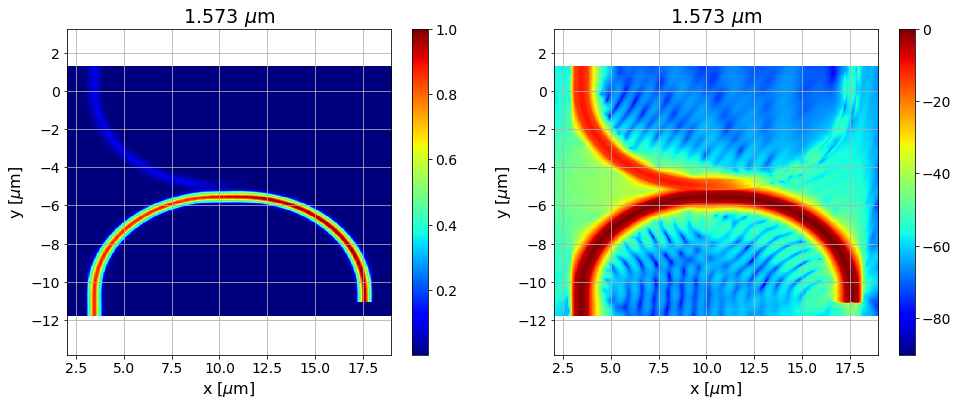

In [101]:
# Plot E field
indxLambda = 4
x_efielf = fdtdApi.getdata("monitor", "x")
y_efielf = fdtdApi.getdata("monitor", "y")
lmbd = nu2lambda(fdtdApi.getdata("monitor", "f"))
xmin = 1e6*np.min(x_efielf);
xmax = 1e6*np.max(x_efielf);
ymin = 1e6*np.min(y_efielf);
ymax = 1e6*np.max(y_efielf);

fig1, axs1 = plt.subplots(1,2,figsize=(16,6))
im1 = axs1[0].imshow(np.rot90(eField[:,:,indxLambda]), cmap = 'jet', extent=[xmin, xmax, ymin, ymax])
fig1.colorbar(im1, ax=axs1[0])
axs1[0].set_xlabel(r'x [$\mu$m]')
axs1[0].set_ylabel(r'y [$\mu$m]')
axs1[0].set_title(r'%4.3f $\mu$m'%(1e6*lmbd[indxLambda]))
axs1[0].grid(True)
axs1[0].axis('equal')

im2 = axs1[1].imshow(10*np.log10(np.rot90(eField[:,:,indxLambda])), cmap = 'jet', extent=[xmin, xmax, ymin, ymax])
fig1.colorbar(im2, ax=axs1[1])
axs1[1].set_xlabel(r'x [$\mu$m]')
axs1[1].set_ylabel(r'y [$\mu$m]')
axs1[1].set_title(r'%4.3f $\mu$m'%(1e6*lmbd[indxLambda]))
axs1[1].grid(True)
axs1[1].axis('equal')

fig1.tight_layout
plt.rcParams.update({'font.size': 16})

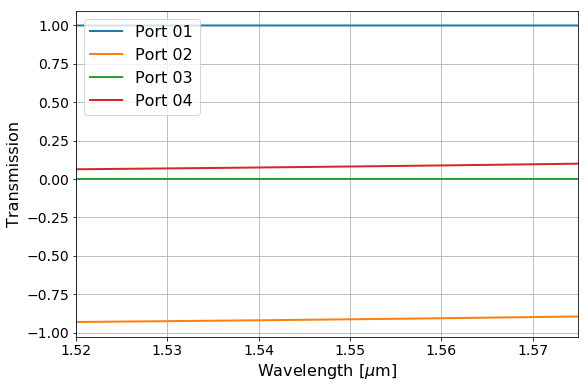

In [102]:
fig2 = plt.figure(figsize=(9,6))
for i in range(4):
    ports = fdtdApi.getresult("FDTD::ports::port %d" %(i+1), "T")
    plt.plot(1e6*ports['lambda'], ports['T'], label = "Port 0%d" %(i+1), linewidth = 2)
    
plt.xlabel(r'Wavelength [$\mu$m]')
plt.ylabel('Transmission')
plt.xlim([1e6*wvlngth_start,1e6*wvlngth_stop])
plt.grid(True)
plt.legend(loc='upper left')

In [103]:
# Simulate for differents lengths
fdtdApi.switchtolayout()
fdtdApi.setnamed("monitor", "enabled", 1)
lc_start = 0e-6
lc_stop  = 18e-6
lc_points = 13
lc = np.linspace(lc_start, lc_stop, lc_points)
for i in range(len(lc)):
    lc_wav = lc[i]
    fdtdApi.switchtolayout()
    
    simulation_time = (np.pi*rad+lc_wav)*7/c+200e-15
    fdtdApi.setnamed("FDTD", "simulation time", simulation_time)
    
    fdtdApi.setnamed("arc00", "x", 2*rad + lc_wav)
    fdtdApi.setnamed("arc03", "x", 2*rad + lc_wav)   
    
    if (lc_wav == 0):
        fdtdApi.setnamed("wav01", "enabled", 0)
        fdtdApi.setnamed("wav02", "enabled", 0)
    else:
        fdtdApi.setnamed("wav01", "enabled", 1)
        fdtdApi.setnamed("wav02", "enabled", 1)
        fdtdApi.setnamed("wav01", "x", 2*rad+lc_wav/2)
        fdtdApi.setnamed("wav01", "x span", lc_wav)
        fdtdApi.setnamed("wav02", "x", 2*rad+lc_wav/2)
        fdtdApi.setnamed("wav02", "x span", lc_wav)
    
    fdtdApi.setnamed("port00", "x", lc_wav+3*rad)
    fdtdApi.setnamed("port02", "x", lc_wav+3*rad)
    
    fdtdApi.setnamed("FDTD", "x", lc_wav/2+2*rad)
    fdtdApi.setnamed("FDTD", "x span", lc_wav+2*rad+portBcDist)
    
    fdtdApi.setnamed("monitor", "x", lc_wav/2+2*rad)
    fdtdApi.setnamed("monitor", "x span", lc_wav+2*rad+portBcDist)

    fdtdApi.setnamed("FDTD::ports::port 1", "x", lc_wav+3*rad)
    fdtdApi.setnamed("FDTD::ports::port 3", "x", lc_wav+3*rad)
    
    if cband:
        filename = "S_DC_FDTD_red_cBand_%d_nm_%03d_um" %(1e9*gap,1e7*lc_wav)
    else:
        filename = "S_DC_FDTD_red_lBand_%d_nm_%03d_um" %(1e9*gap,1e7*lc_wav)
        
    fdtdApi.save(filename)
        
    scriptAnalysis = "filename = \"%s.dat\";\n" %(filename)
    scriptAnalysis = scriptAnalysis + "port1 = getresult(\"FDTD::ports::port 1\", \"expansion for port monitor\");\n"
    scriptAnalysis = scriptAnalysis + "port2 = getresult(\"FDTD::ports::port 2\", \"expansion for port monitor\");\n"
    scriptAnalysis = scriptAnalysis + "port3 = getresult(\"FDTD::ports::port 3\", \"expansion for port monitor\");\n"
    scriptAnalysis = scriptAnalysis + "port4 = getresult(\"FDTD::ports::port 4\", \"expansion for port monitor\");\n"
    scriptAnalysis = scriptAnalysis + "S11 = S22 = S33 = S44 = port1.b/port1.a;\n"
    scriptAnalysis = scriptAnalysis + "S21 = S12 = S34 = S43 = port2.b/port1.a;\n"
    scriptAnalysis = scriptAnalysis + "S31 = S13 = S24 = S42 = port3.a/port1.a;\n"
    scriptAnalysis = scriptAnalysis + "S41 = S14 = S23 = S32 = port4.a/port1.a;\n"
    scriptAnalysis = scriptAnalysis + "S = matrixdataset;\n"
    scriptAnalysis = scriptAnalysis + "S.addparameter(\"f\", port1.f, \"lambda\", port1.lambda);\n"
    scriptAnalysis = scriptAnalysis + "S.addattribute(\"S11\", S11);\n"
    scriptAnalysis = scriptAnalysis + "S.addattribute(\"S21\", S21);\n"
    scriptAnalysis = scriptAnalysis + "S.addattribute(\"S31\", S31);\n"
    scriptAnalysis = scriptAnalysis + "S.addattribute(\"S41\", S41);\n"
    scriptAnalysis = scriptAnalysis + "S.addattribute(\"S22\", S22);\n"
    scriptAnalysis = scriptAnalysis + "S.addattribute(\"S12\", S12);\n"
    scriptAnalysis = scriptAnalysis + "S.addattribute(\"S13\", S13);\n"
    scriptAnalysis = scriptAnalysis + "S.addattribute(\"S14\", S14);\n"
    scriptAnalysis = scriptAnalysis + "S.addattribute(\"S33\", S33);\n"
    scriptAnalysis = scriptAnalysis + "S.addattribute(\"S34\", S34);\n"
    scriptAnalysis = scriptAnalysis + "S.addattribute(\"S24\", S24);\n"
    scriptAnalysis = scriptAnalysis + "S.addattribute(\"S23\", S23);\n"
    scriptAnalysis = scriptAnalysis + "S.addattribute(\"S44\", S44);\n"
    scriptAnalysis = scriptAnalysis + "S.addattribute(\"S43\", S43);\n"
    scriptAnalysis = scriptAnalysis + "S.addattribute(\"S42\", S42);\n"
    scriptAnalysis = scriptAnalysis + "S.addattribute(\"S32\", S32);\n"        
    scriptAnalysis = scriptAnalysis + "# export to file for INTERCONNECT\n"
    scriptAnalysis = scriptAnalysis + "myStr = \"[2,2]\";\n"
    scriptAnalysis = scriptAnalysis + "myMatrix = [S.f, abs(S11), unwrap(angle(S11))];\n"
    scriptAnalysis = scriptAnalysis + "for (outPort = 1:4) {\n"
    scriptAnalysis = scriptAnalysis + "    for (inPort = 1:4) {\n"    
    scriptAnalysis = scriptAnalysis + r'        myStr = myStr + "\n(\"port " + num2str(outPort) + "\", \"TE\", 1, \"port " + num2str(inPort) + "\", 1, \"transmission\")\n(" + num2str(length(S.f)) + ", 3)\n";'
    scriptAnalysis = scriptAnalysis + "\n        eval(\"myMatrix = [S.f, abs(S\" + num2str(outPort) + num2str(inPort) +\"), unwrap(angle(S\" + num2str(outPort) + num2str(inPort) + \"))];\");\n"    
    scriptAnalysis = scriptAnalysis + "        myStr = myStr + num2str(myMatrix);\n"
    scriptAnalysis = scriptAnalysis + "}}\n"
    scriptAnalysis = scriptAnalysis + "if(fileexists(filename)) { rm(filename); }\n"
    scriptAnalysis = scriptAnalysis + "format long;\nwrite(filename,myStr);\nformat short;"
    fdtdApi.setnamed("::model::", "analysis script", scriptAnalysis)
        
    fdtdApi.run()
    fdtdApi.runanalysis()
    fdtdApi.save(filename)

## Variar o comprimento de acoplamento

Aqui o comprimento de acoplamento será alterado e os parâmetros S serão salvos para posterior uso no INTERCONNECT.

In [71]:
from scipy.optimize import curve_fit

In [72]:
lumapiFile = "C:\\Program Files\\Lumerical\\v211\\api\\python\\lumapi.py"
lumapi    = imp.load_source("lumapi", lumapiFile)
intccApi  = lumapi.INTERCONNECT(hide = False)

Exception ignored in: <function Lumerical.__del__ at 0x00000180D8CA8AF0>
Traceback (most recent call last):
  File "C:\Program Files\Lumerical\v211\api\python\lumapi.py", line 1171, in __del__
    close(self.handle)
  File "C:\Program Files\Lumerical\v211\api\python\lumapi.py", line 241, in close
    iapi.appClose(handle)
ctypes.ArgumentError: argument 1: <class 'TypeError'>: expected Session instance instead of Session


In [73]:
def setElementPosition(intccObj, elementObj, xPos, yPos):
    intccObj.setnamed(elementObj, "x position", xPos)
    intccObj.setnamed(elementObj, "y position", yPos)

In [74]:
# C Band simulation: 1520 - 1575 nm
# L Band simulation: 1555 - 1635 nm
gap = 150e-9
lc_wav = 0
cband = True
if cband:
    wvlngth_start = 1.520e-6
    wvlngth_stop  = 1.575e-6
else:
    wvlngth_start = 1.555e-6
    wvlngth_stop  = 1.635e-6    

In [76]:
dirFile = 'DC_FDTD_cband_red_215nm\\'
if cband:
    filename = "S_DC_FDTD_red_cBand_%d_nm_%03d_um" %(1e9*gap,1e7*lc_wav)
else:
    filename = "S_DC_FDTD_red_lBand_%d_nm_%03d_um" %(1e9*gap,1e7*lc_wav)

In [77]:
sampleRate = 8e12 # Taxa de amostragem
timeWindow = 20e-9 # Janela de simulação
lmbdCenter = (wvlngth_start + wvlngth_stop)/2

In [78]:
simOpticalBand = (sampleRate*lmbdCenter**2)/c
print('Comprimento de onda central [nm]: %6.2f' %(1e9*lmbdCenter))
print('Janela de simulação [nm]: %f - [%6.2f nm - %6.2f nm]' 
      %(1e9*simOpticalBand, 1e9*(lmbdCenter-simOpticalBand/2), 1e9*(lmbdCenter+simOpticalBand/2)))
print('Distância entre pontos [GHz]: %f' %(1e-9/timeWindow))
print('Número total de pontos: %d' %(sampleRate*timeWindow))

Comprimento de onda central [nm]: 1547.50
Janela de simulação [nm]: 63.904376 - [1515.55 nm - 1579.45 nm]
Distância entre pontos [GHz]: 0.050000
Número total de pontos: 160000


In [79]:
intccApi.setnamed("::Root Element", "simulation input", "sample rate")
intccApi.setnamed("::Root Element", "sample rate", sampleRate)
intccApi.setnamed("::Root Element", "time window", timeWindow)
intccApi.setnamed("::Root Element", "multithreading", "automatic")

intccApi.annotateproperty("::Root Element::", "simulation input", True)
intccApi.annotateproperty("::Root Element::", "bitrate", True)
intccApi.annotateproperty("::Root Element::", "time window", True)
intccApi.annotateproperty("::Root Element::", "sample rate", True)
intccApi.annotateproperty("::Root Element::", "number of samples", True)

In [80]:
intccApi.addelement("Optical N Port S-Parameter")
intccApi.set("name", "N_port_01")
intccApi.set("load from file", True)
intccApi.set("s parameters filename", "%s.dat" %(dirFile + filename))

In [81]:
intccApi.addelement("Optical Network Analyzer")
intccApi.set("name", "ONA_01")
intccApi.set("number of input ports", 4)
intccApi.set("center frequency", nu2lambda(lmbdCenter))
intccApi.set("frequency range", sampleRate)
intccApi.set("number of points", sampleRate*timeWindow)

In [82]:
offsetX = 0
offsetY = 150
setElementPosition(intccApi, "ONA_01",    -200 + offsetX, -200 + offsetY)
setElementPosition(intccApi, "N_port_01", offsetX, offsetY)

In [83]:
intccApi.connect("ONA_01", "output",  "N_port_01", "port 1") 
intccApi.connect("ONA_01", "input 1", "N_port_01", "port 1")
intccApi.connect("ONA_01", "input 2", "N_port_01", "port 2")
intccApi.connect("ONA_01", "input 3", "N_port_01", "port 3")
intccApi.connect("ONA_01", "input 4", "N_port_01", "port 4")

1.0

In [84]:
#lc_start = 0e-6
#lc_stop  = 18e-6
#lc_points = 13
lc_start = 0e-6
lc_stop = 28e-6
lc_points = 21
lc = np.linspace(lc_start, lc_stop, lc_points)
data01 = np.zeros([len(lc), int(sampleRate*timeWindow)],dtype = 'complex_')
data02 = np.zeros([len(lc), int(sampleRate*timeWindow)],dtype = 'complex_')
data03 = np.zeros([len(lc), int(sampleRate*timeWindow)],dtype = 'complex_')
data04 = np.zeros([len(lc), int(sampleRate*timeWindow)],dtype = 'complex_')
for i in range(len(lc)):
    lc_wav = lc[i]
    if cband:
        filename = "S_DC_FDTD_red_cBand_%d_nm_%03d_um" %(1e9*gap,1e7*lc_wav)
    else:
        filename = "S_DC_FDTD_red_lBand_%d_nm_%03d_um" %(1e9*gap,1e7*lc_wav)
    intccApi.switchtolayout()
    intccApi.setnamed("N_port_01", "s parameters filename", "%s.dat" %(dirFile + filename))
    intccApi.run()
    data01[i, :] = intccApi.getresult("ONA_01", "input 1/mode 1/transmission")['TE transmission']
    data02[i, :] = intccApi.getresult("ONA_01", "input 2/mode 1/transmission")['TE transmission']
    data03[i, :] = intccApi.getresult("ONA_01", "input 3/mode 1/transmission")['TE transmission']
    data04[i, :] = intccApi.getresult("ONA_01", "input 4/mode 1/transmission")['TE transmission']

In [85]:
lmbd = intccApi.getresult("ONA_01", "input 4/mode 1/transmission")['wavelength']

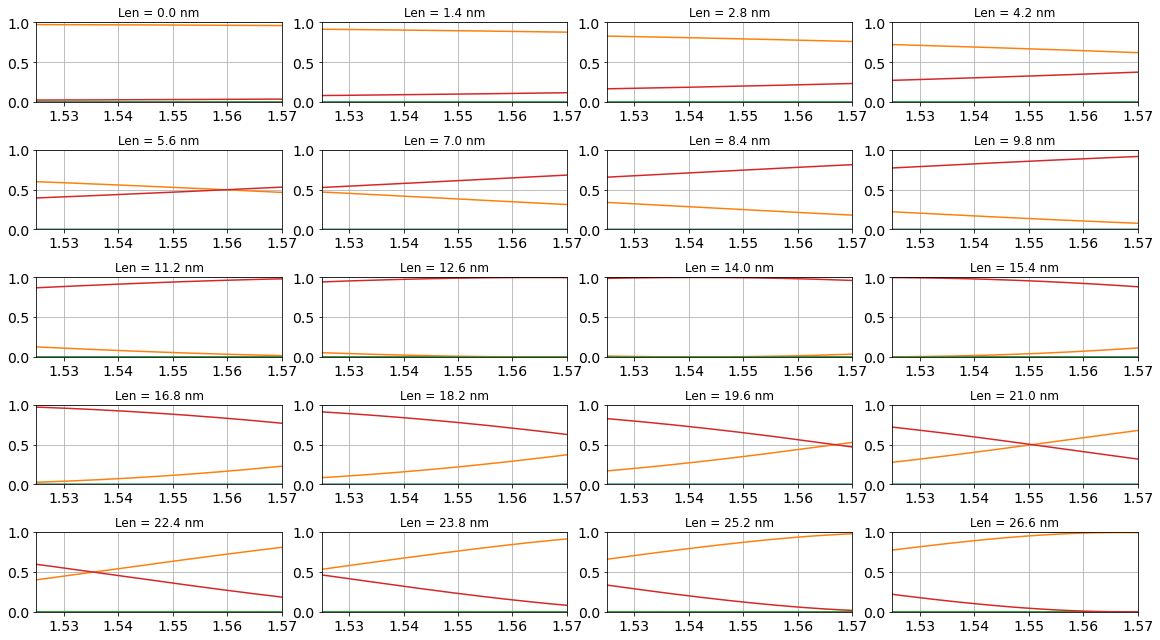

In [86]:
if cband:
    band_max = 1.570
    band_min = 1.525
else:
    band_max = 1.630
    band_min = 1.560
rowIdx = np.array([0,0,0,0,1,1,1,1,2,2,2,2,3,3,3,3,4,4,4,4])
fig3, axs3 = plt.subplots(5,4,figsize=(16,9))
for i in range(len(rowIdx)):
    axs3[rowIdx[i],np.mod(i,4)].plot(1e6*lmbd,np.abs(data01[i, :])**2)
    axs3[rowIdx[i],np.mod(i,4)].plot(1e6*lmbd,np.abs(data02[i, :])**2)
    axs3[rowIdx[i],np.mod(i,4)].plot(1e6*lmbd,np.abs(data03[i, :])**2)
    axs3[rowIdx[i],np.mod(i,4)].plot(1e6*lmbd,np.abs(data04[i, :])**2)
    axs3[rowIdx[i],np.mod(i,4)].set_xlim([band_min,band_max])
    axs3[rowIdx[i],np.mod(i,4)].set_ylim([0,1])
    axs3[rowIdx[i],np.mod(i,4)].grid(True)
    axs3[rowIdx[i],np.mod(i,4)].set_title('Len = %3.1f nm' %(1e6*lc[i]))
    
plt.tight_layout()

In [87]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx,array[idx]

In [88]:
nmblmbdPnts = 9
if cband:
    lmbdPnts = np.linspace(1.53,1.57,nmblmbdPnts)
else:
    lmbdPnts = np.linspace(1.57,1.625,nmblmbdPnts)
dataFit_Cross   = np.zeros([lc_points, nmblmbdPnts])
dataFit_Through = np.zeros([lc_points, nmblmbdPnts])
dataFit_lmbd = np.zeros(nmblmbdPnts)

In [89]:
for i in range(nmblmbdPnts):
    idxE, vlE = find_nearest(1e6*lmbd, lmbdPnts[i])
    dataFit_Cross[:,i]   = np.abs(data03[:, idxE])**2
    dataFit_Through[:,i] = np.abs(data04[:, idxE])**2
    dataFit_lmbd[i] = vlE
dataFit_Sum = np.sqrt(dataFit_Cross + dataFit_Through)

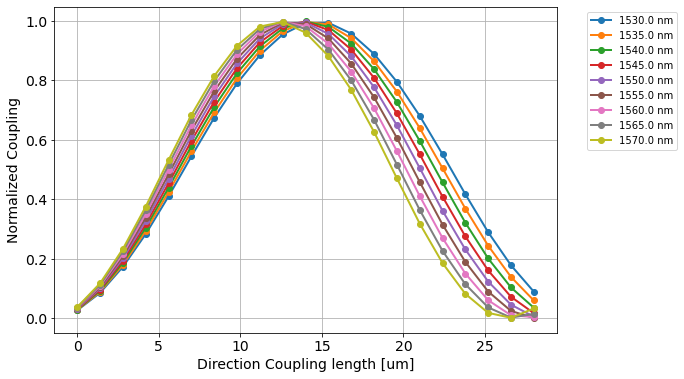

In [90]:
fig4 = plt.figure(figsize=(9,6))
plt.rc('xtick',labelsize=14)
plt.rc('ytick',labelsize=14)
for i in range(nmblmbdPnts):
    #plt.plot(1e6*lc,dataFit_Cross, '-x')
    plt.plot(1e6*lc,dataFit_Through[:,i], '-o', label = "%5.1f nm" %(1e3*dataFit_lmbd[i]), linewidth = 2)
    #plt.plot(1e6*lc,dataFit_Sum, '-o')
plt.xlabel('Direction Coupling length [um]', fontsize = 14)
plt.ylabel('Normalized Coupling', fontsize = 14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.savefig(dirFile + filename[0:26] + '_210_nm_' + 'all_wav.png', bbox_inches='tight')

In [91]:
def func_k(x, kl, kb):
    return (np.sin(x*kl+kb))**2

In [92]:
klV = np.zeros(nmblmbdPnts)
kbV = np.zeros(nmblmbdPnts)
for i in range(nmblmbdPnts):
    popt, pcov = curve_fit(func_k, 1e6*lc, dataFit_Through[:,i], bounds=(0,[0.3,0.3]))
    klV[i]=popt[0]
    kbV[i]=popt[1]

In [93]:
# From document @1550 nm
x_data = np.array([0, 0.8255933952528385, 2.6315789473684212, 3.9215686274509807, 6.578947368421053, 9.287925696594428, 10.603715170278639, 12.358101135190918, 14.73168214654283, 17.053663570691437, 18.808049535603715, 20.098039215686274])
y_data = np.array([0.03684210526315801, 0.07758812666340786, 0.20644044321329658, 0.3274251805985554, 0.6128116343490305, 0.8626690565422845, 0.9441787518331433, 0.9967179946770953, 0.9610667535712347, 0.8083129650752269, 0.6424311552875999, 0.5042053663570693])

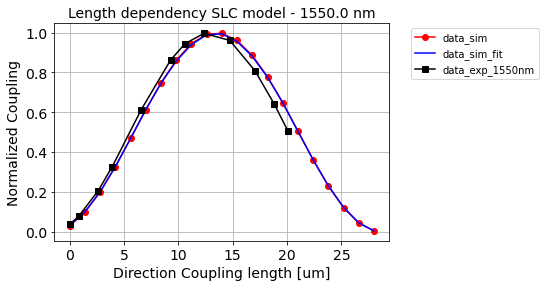

In [94]:
lmbdCh = 4
plt.figure()
plt.plot(1e6*lc, func_k(1e6*lc, klV[lmbdCh], kbV[lmbdCh]), 'r-o', label = 'data_sim')
plt.plot(1e6*lc, dataFit_Through[:,lmbdCh],'b-', label = 'data_sim_fit')
plt.plot(x_data, y_data, 'sk-', label = 'data_exp_1550nm')
plt.xlabel('Direction Coupling length [um]', fontsize = 14)
plt.ylabel('Normalized Coupling', fontsize = 14)
plt.title('Length dependency SLC model - %5.1f nm' %(1e3*dataFit_lmbd[lmbdCh]), fontsize = 14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.savefig(dirFile + filename[0:26] + '_210_nm_' + '1550nm.png', bbox_inches='tight')

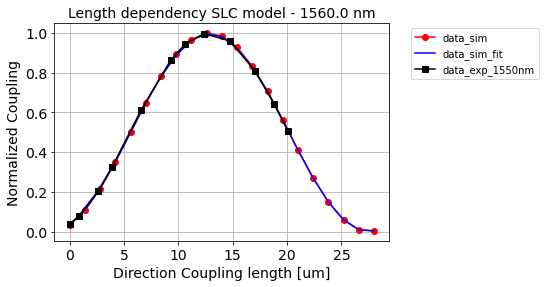

In [95]:
lmbdCh = 6
plt.figure()
plt.plot(1e6*lc, func_k(1e6*lc, klV[lmbdCh], kbV[lmbdCh]), 'r-o', label = 'data_sim')
plt.plot(1e6*lc, dataFit_Through[:,lmbdCh],'b-', label = 'data_sim_fit')
plt.plot(x_data, y_data, 'sk-', label = 'data_exp_1550nm')
plt.xlabel('Direction Coupling length [um]', fontsize = 14)
plt.ylabel('Normalized Coupling', fontsize = 14)
plt.title('Length dependency SLC model - %5.1f nm' %(1e3*dataFit_lmbd[lmbdCh]), fontsize = 14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.savefig(dirFile + filename[0:26] + '_210_nm_' + '1560nm.png', bbox_inches='tight')

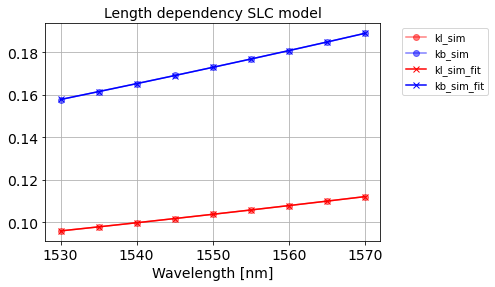

In [96]:
plt.figure()
plt.plot(1e3*dataFit_lmbd, klV, 'r-o', alpha = 0.5, label = 'kl_sim')
plt.plot(1e3*dataFit_lmbd, kbV, 'b-o', alpha = 0.5, label = 'kb_sim')

klC = np.poly1d(np.polyfit(1e3*dataFit_lmbd, klV, 2))
kbC = np.poly1d(np.polyfit(1e3*dataFit_lmbd, kbV, 2))
plt.plot(1e3*dataFit_lmbd, klC(1e3*dataFit_lmbd), 'r-x', label = 'kl_sim_fit')
plt.plot(1e3*dataFit_lmbd, kbC(1e3*dataFit_lmbd), 'b-x', label = 'kb_sim_fit')

plt.xlabel('Wavelength [nm]', fontsize = 14)
plt.title('Length dependency SLC model', fontsize = 14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.savefig(dirFile + filename[0:26] + '_210_nm_sim.png', bbox_inches='tight')

In [97]:
klC

poly1d([ 6.26448447e-07, -1.53792348e-03,  9.82462103e-01])

In [98]:
kbC

poly1d([ 1.09440992e-06, -2.61363166e-03,  1.59477728e+00])

## Considerando apenas dados na banda C (dados experimentais)

In [99]:
kla = 5.65249464e-7; klb = -1.31796995e-3; klc = 7.95009694e-1;

In [100]:
kba = 6.67618538e-6; kbb = -1.99962431e-2; kbc = 1.51475471e1;

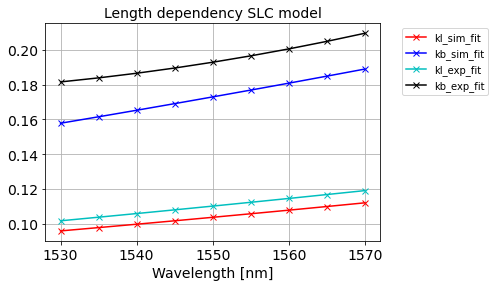

In [101]:
y_kl_expData = kla * (1e3*dataFit_lmbd)**2 + klb * 1e3*dataFit_lmbd + klc;
y_kb_expData = kba * (1e3*dataFit_lmbd)**2 + kbb * 1e3*dataFit_lmbd + kbc;
plt.plot(1e3*dataFit_lmbd, klC(1e3*dataFit_lmbd), 'r-x', label = 'kl_sim_fit')
plt.plot(1e3*dataFit_lmbd, kbC(1e3*dataFit_lmbd), 'b-x', label = 'kb_sim_fit')
plt.plot(1e3*dataFit_lmbd, y_kl_expData, 'c-x', label = 'kl_exp_fit')
plt.plot(1e3*dataFit_lmbd, y_kb_expData, 'k-x', label = 'kb_exp_fit')
plt.xlabel('Wavelength [nm]', fontsize = 14)
plt.title('Length dependency SLC model', fontsize = 14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.savefig(dirFile + filename[0:26] + '_210_nm_sim_exp.png', bbox_inches='tight')

## intccApi.close()